In [1]:
%pylab inline
import scipy
import h5py
import skimage
import os
from skimage import io,transform,img_as_float
from skimage.io import imread,imsave
from collections import OrderedDict
import decimal
notebook_dir = os.getcwd()
project_dir = os.path.split(notebook_dir)[0]
result_dir = project_dir + '/Results/Images/'
if not os.path.isdir(result_dir):
    os.makedirs(result_dir)
tmp_dir = project_dir + '/Tmp/'
if not os.path.isdir(tmp_dir):
    os.makedirs(tmp_dir)
photo_dir = project_dir + '/Images/ControlPaper/'
art_dir = project_dir + '/Images/ControlPaper/'

Populating the interactive namespace from numpy and matplotlib


In [2]:
def make_torch_input(filename, layers, loss_functions, args):
    f = h5py.File(filename,'w')
    for l,layer in enumerate(layers):
        layer_group = f.create_group(layer)
        for lf,loss_function in enumerate(loss_functions[l]):
            lf_group = layer_group.create_group(loss_function)
            for arg in args[l][lf]:
                dataset = lf_group.create_dataset(arg, data=args[l][lf][arg])
    f.close()
    
def make_torch_init(filename, init):
    f = h5py.File(filename,'w')
    f.create_dataset('init', data=init)
    f.close()

def get_torch_output(filename):
    f = h5py.File(filename,'r')
    data = f['opt_result']
    return data.value
    f.close()
def get_torch_loss(filename):
    f = h5py.File(filename,'r')
    data = f['losses']
    return data.value
    f.close()

def list2css(layers):
    '''
    Takes list of strings and returns comma separated string
    '''
    css = str()
    for l in layers:
        css = css+str(l)+','
    return css[:-1]

def get_activations(images, caffe_model, layers='all', gpu=0):
    '''
    Function to get neural network activations in response to images from torch.
    
    :param images: array of images
    :param caffe_model: file name of the network .caffemodel file
    :param layers: network layers for which the activations should be computed
    :return: network activations in response to images
    '''
    layers = list2css(layers)
    images_file_name = tmp_dir + 'images.hdf5'
    output_file_name = tmp_dir + 'activations.hdf5'
    f = h5py.File(images_file_name, 'w')
    f.create_dataset('images', data=images)
    f.close()
    context = {
    'caffe_model': caffe_model,
    'images': images_file_name,
    'layers': layers,
    'gpu': gpu,
    'backend': 'cudnn',
    'output_file': output_file_name,
    'project_dir': project_dir
    }
    template = ('#!/bin/bash\n' +
                'cd {project_dir} && ' + 
                'th ComputeActivations.lua ' + 
                '-caffe_model {caffe_model} ' +
                '-images {images} ' + 
                '-layers {layers} ' + 
                '-gpu {gpu} ' + 
                '-backend {backend} ' +
                '-output_file {output_file}')
    script_name = project_dir + '/get_activations.sh'
    with open(script_name, 'w') as script:
        script.write(template.format(**context))
    os.chmod(script_name, 0o755)
    #execute script 
    !{script_name} >/dev/null
    f = h5py.File(output_file_name,'r')
    act = OrderedDict()
    for key in f.keys():
        act[key] = f[key].value.copy()
    f.close()
    return act

def preprocess(image):
    assert(image.max() <= (1. + 1e3))
    imagenet_mean = array([0.40760392,  0.45795686,  0.48501961])
    image_torch = 255 * (image[:,:,::-1] - imagenet_mean).transpose(2,0,1)
    return image_torch

def deprocess(image_torch):
    imagenet_mean = array([0.40760392,  0.45795686,  0.48501961])
    image = (image_torch.transpose(1,2,0)/255. + imagenet_mean)[:,:,::-1]
    image[image>1] = 1
    image[image<0] = 0
    return image

def gram_matrix(activations):
    n_fm = activations.shape[0]
    F = activations.reshape(n_fm,-1)
    G = F.dot(F.T) / F[0,:].size
    return G

def gram_matrix_guided(activations, guides):
    '''
    guides is array of dimensions (n_ch,h,w) that defines n_ch guidance channels
    guides should be normalised as: guides = guides / np.sqrt(np.diag(gram_matrix(guides)))[:,None,None]
    activations are of dimensions (n_fm,h,w), the n_fm feature maps of a CNN layer
    Output are n_ch gram matrices, that were computed with the feature maps weighted by the guidance channel
    '''
    assert (guides.sum(1).sum(1)==0).sum()==0, 'Dont use empty guidance channels'
    assert guides.dtype == float, 'Guides should be float'
    n_fm = activations.shape[0]
    n_ch = guides.shape[0]
    G = np.zeros((n_ch,n_fm,n_fm))
    for c in range(n_ch):
        F = (activations * guides[c,:,:]).reshape(n_fm,-1)
        G[c,:,:] = F.dot(F.T) / F[0,:].size
    return G

def mean_fm_guided(activations, guides):
    assert (guides.sum(1).sum(1)==0).sum()==0, 'Dont use empty guidance channels'
    assert guides.dtype == float, 'Guides should be float'
    n_fm = activations.shape[0]
    n_ch = guides.shape[0]
    M = np.zeros((n_ch,n_fm))
    for c in range(n_ch):
        F = (activations * guides[c,:,:]).reshape(n_fm,-1)
        M[c,:] = F.mean(1)
    return M

import itertools
def flatten(l):
    return list(itertools.chain.from_iterable(l))

def set_model(name, project_dir):
    if name == 'org_pad':
        model = project_dir + '/Models/VGG_ILSVRC_19_layers_conv.caffemodel'
    elif name == 'norm_pad':
        model = project_dir + '/Models/vgg_normalised.caffemodel'
    else:
        assert False, 'unknown model name'
    return model
    
def get_fm_guides(guides, caffe_model, layers, mode='simple', k=0, th=.5, batch_size=2):
    '''
    Function to get guides on the feature maps of layers given guides on the pixels
    
    :param guides: the pixel guides
    :param project_dir: the main directory, needed for computing the activations
    :param caffe_model: the network model to compute the guides for
    :param layers: the layers on which to compute the guides
    :param mode: the mode of obtaining the feature map guide: simple|all|inside, downsampling|all neurons that see region| neurons that see only region 
    :param k: optionally can extend or reduce fm guides by k pixels 
    :param th: threshold to make guides binary, only used for modes all|inside 
    :param batch_size: batch_size for probing which neurons see the guide
    '''
    fm_guides = OrderedDict()
    if mode=='simple':
        probe_image = zeros((3,) + guides.shape[:-1])
        probe_image += 1e2 * randn(*probe_image.shape)
        feature_maps = get_activations(probe_image, caffe_model, layers=layers)
        for layer in layers:
            sf = asarray(feature_maps[layer].shape).astype(float) / asarray(guides.transpose(2,0,1).shape)
            sf[0] = 1
            fm_guides[layer] = scipy.ndimage.zoom(guides.transpose(2,0,1), sf, mode='nearest')
        if k != 0:
            n_guides = guides.shape[2]
            for layer in layers:
                fm_guides[layer][fm_guides[layer]<th] = 0
                fm_guides[layer][fm_guides[layer]>th] = 1
                if k>0:
                    #extend fm guides
                    for m in range(n_guides):
                        fm_guides[layer][m,:,:] = (scipy.ndimage.filters.uniform_filter(fm_guides[layer][m,:,:],(2*k+1))>=(1./(2*k+1)**2)).astype(float)
                elif k<0:
                    #reduce fm guides
                    for m in range(n_guides):
                        fm_guides[layer][m,:,:][scipy.ndimage.filters.uniform_filter(fm_guides[layer][m,:,:],(2*(-k)+1))<(1-1./(2*(-k)+1)**2)] = 0.
    else:
        n_guides = guides.shape[2]
        for m in range(n_guides):
            guide = guides[:,:,m]
            guide[guide<th] = 0
            guide[guide>=th] = 1

            if mode=='all':
                probe_image = zeros((batch_size, 3,) + guide.shape)
                probe_image[:,:,guide.astype(bool)] += 1e2 * randn(*probe_image[:,:,guide.astype(bool)].shape)
                feature_maps = get_activations(probe_image, caffe_model, layers=layers)
                for layer in layers:
                    if m==0:
                        fm_guides[layer] = []
                    fm_guides[layer].append((feature_maps[layer].var(0).mean(0)!=0).astype(float))

            elif mode=='inside':
                inv_guide = guide.copy()-1
                inv_guide *= -1
                probe_image_out = zeros((batch_size, 3,) + inv_guide.shape)
                probe_image_out[:,:,inv_guide.astype(bool)] += 1e2 * randn(*probe_image_out[:,:,inv_guide.astype(bool)].shape)
                feature_maps_out = get_activations(probe_image_out, caffe_model, layers=layers)
                for layer in layers:
                    if m==0:
                        fm_guides[layer] = []
                    fm_guides[layer].append((feature_maps_out[layer].var(0).mean(0)==0).astype(float))
        for layer in layers:
            fm_guides[layer] = np.stack(fm_guides[layer])
            
        if k>0:
            #extend fm guides
            for layer in layers:
                for m in range(n_guides):
                    fm_guides[layer][m,:,:] = (scipy.ndimage.filters.uniform_filter(fm_guides[layer][m,:,:],(2*k+1))>=(1./(2*k+1)**2)).astype(float)
        elif k<0:
            #reduce fm guides
            for layer in layers:
                for m in range(n_guides):
                    fm_guides[layer][m,:,:][scipy.ndimage.filters.uniform_filter(fm_guides[layer][m,:,:],(2*(-k)+1))<(1-1./(2*(-k)+1)**2)] = 0.
    return fm_guides

# Guided sums with Gram 

##  One style image

### org net 

In [7]:
img_dirs = OrderedDict()
img_names = OrderedDict()
guide_dirs = OrderedDict()
img_dirs['content'] = photo_dir
img_dirs['style'] = art_dir
img_names['style'] = 'fig2_style1.jpg'
img_names['content'] = 'fig2_content.jpg'
guide_dirs['content'] = photo_dir
guide_dirs['style'] = art_dir
regions = ['sky','nosky']
layers = OrderedDict()
layers['style'] = ['relu1_1','relu2_1','relu3_1','relu4_1','relu5_1']
layers['content'] =  ['relu4_2']
layers_now = layers['style'] + layers['content']
loss_functions = [['MeanMSEGuided', 'GramMSE']] * len(layers['style']) + [['MSE']]

guide_mode = 'inside'
k = 0
th = .5 #threshold for guides after downsampling, only relevant for modes inside and all or k != 0
img_size = 512
hr_img_size = 1024
max_iter = 500
hr_max_iter = 200
gpu = 0
model_name = 'org_pad'
caffe_model = set_model(model_name, project_dir)

input_file_name = tmp_dir + 'input_sc.hdf5'
init_file_name = tmp_dir + 'init_sc.hdf5'
output_file_name = tmp_dir + 'output_sc.hdf5'

n_ch = len(regions)
sw = 1e3
mw = 1e9
gw = [1./n_ch]*n_ch
cw = 1
weights = OrderedDict()
weights['style'] = [
    [array([mw/(64**2)]*n_ch)*array(gw), array([sw/(64**2)])],
    [array([mw/(128**2)]*n_ch)*array(gw), array([sw/(128**2)])],
    [array([mw/(256**2)]*n_ch)*array(gw), array([sw/(256**2)])],
    [array([mw/(512**2)]*n_ch)*array(gw), array([sw/(512**2)])],
    [array([mw/(512**2)]*n_ch)*array(gw), array([sw/(512**2)])],
]
weights['content'] = [[array([cw])]]

result_image_name = (
'cimg_' + img_names['content'] + 
'_simg_' + img_names['style'] + 
'_regions_' + list2css(regions) + 
'_mm_' + str(guide_mode) + 
'_k_' + str(k) + 
'_sz_' + str(img_size) + 
'_model_' + model_name + 
'_sw_' + '%.1E'%decimal.Decimal(sw) + 
'_mw_' + '%.1E'%decimal.Decimal(mw) +  
'_cw_' + '%.1E'%decimal.Decimal(cw) +
'_gw_' + list2css(['%.1E'%decimal.Decimal(i) for i in gw]) + 
# '_gw_equal_' + '%.1E'%decimal.Decimal(gw[0]) +  
'_layers_' + list2css(layers_now) + 
'_gram_guided_mean' + 
'.jpg'
)

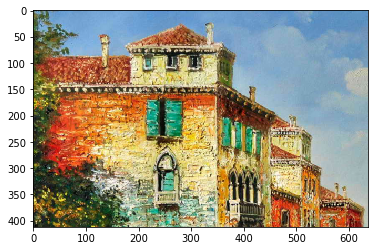

sky


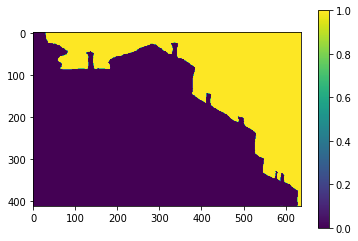

nosky


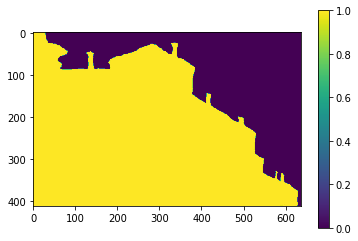

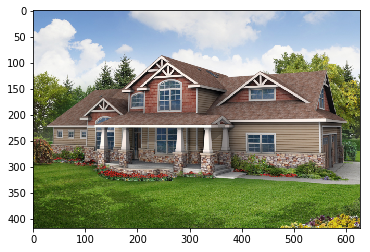

sky


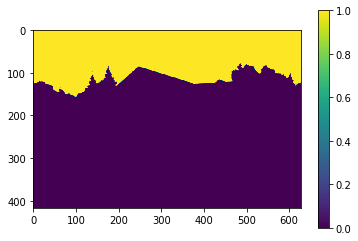

nosky


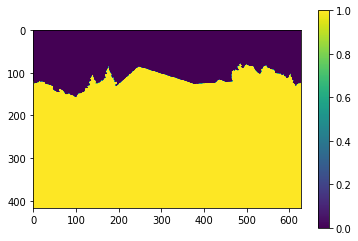

Successfully loaded /home/fanfanda/style_transfer/fanfanda_neuralImages/NeuralImageSynthesis/Models/VGG_ILSVRC_19_layers_conv.caffemodel
conv1_1: 64 3 3 3
conv1_2: 64 64 3 3
conv2_1: 128 64 3 3
conv2_2: 128 128 3 3
conv3_1: 256 128 3 3
conv3_2: 256 256 3 3
conv3_3: 256 256 3 3
conv3_4: 256 256 3 3
conv4_1: 512 256 3 3
conv4_2: 512 512 3 3
conv4_3: 512 512 3 3
conv4_4: 512 512 3 3
conv5_1: 512 512 3 3
conv5_2: 512 512 3 3
conv5_3: 512 512 3 3
conv5_4: 512 512 3 3
Running optimization with L-BFGS	
<optim.lbfgs> 	creating recyclable direction/step/history buffers	
Iteration 50 / 500	
relu1_1	
GramMSE loss: 21103.494644	
MeanMSEGuided loss: 6273229.140788	
relu2_1	
GramMSE loss: 357384.216309	
MeanMSEGuided loss: 3395273.699425	
relu3_1	
GramMSE loss: 141718.566895	
MeanMSEGuided loss: 761574.687203	
relu4_1	
GramMSE loss: 1837414.306641	
MeanMSEGuided loss: 761369.359680	
relu5_1	
GramMSE loss: 5896.862984	
MeanMSEGuided loss: 171312.014572	
relu4_2	
MSE loss: 408571.375000	
Total loss: 1

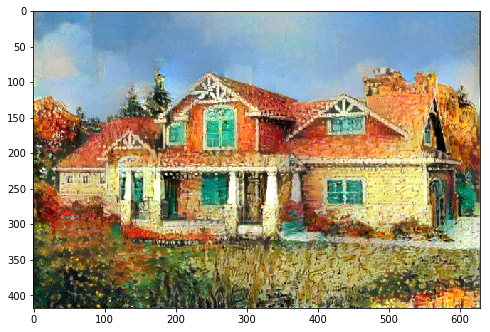

no downsampling: fig2_style1.jpg


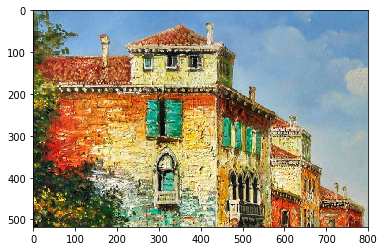

sky


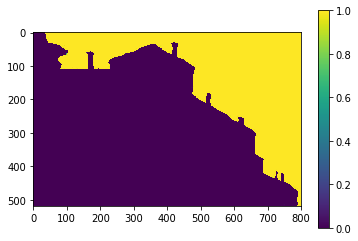

nosky


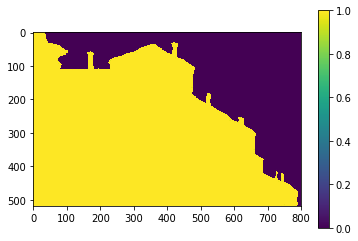

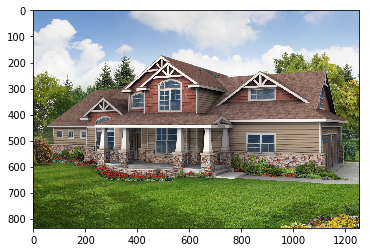

sky


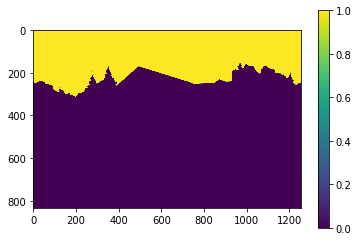

nosky


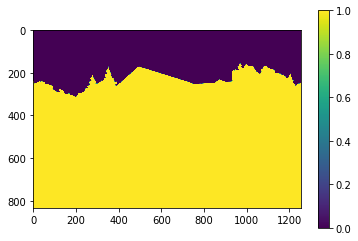

/root/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:170: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.


Successfully loaded /home/fanfanda/style_transfer/fanfanda_neuralImages/NeuralImageSynthesis/Models/VGG_ILSVRC_19_layers_conv.caffemodel
conv1_1: 64 3 3 3
conv1_2: 64 64 3 3
conv2_1: 128 64 3 3
conv2_2: 128 128 3 3
conv3_1: 256 128 3 3
conv3_2: 256 256 3 3
conv3_3: 256 256 3 3
conv3_4: 256 256 3 3
conv4_1: 512 256 3 3
conv4_2: 512 512 3 3
conv4_3: 512 512 3 3
conv4_4: 512 512 3 3
conv5_1: 512 512 3 3
conv5_2: 512 512 3 3
conv5_3: 512 512 3 3
conv5_4: 512 512 3 3
Running optimization with L-BFGS	
<optim.lbfgs> 	creating recyclable direction/step/history buffers	
Iteration 50 / 200	
relu1_1	
GramMSE loss: 2358.853579	
MeanMSEGuided loss: 49109.881729	
relu2_1	
GramMSE loss: 171399.124146	
MeanMSEGuided loss: 273836.871202	
relu3_1	
GramMSE loss: 65029.876709	
MeanMSEGuided loss: 149758.241605	
relu4_1	
GramMSE loss: 647152.099609	
MeanMSEGuided loss: 211910.795770	
relu5_1	
GramMSE loss: 2740.040302	
MeanMSEGuided loss: 35407.489122	
relu4_2	
MSE loss: 489170.593750	
Total loss: 2097873.

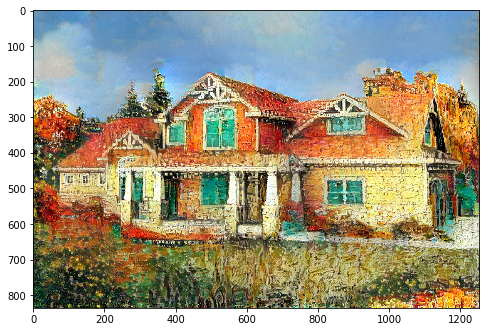

In [8]:
#check if image exists
if os.path.isfile(result_dir + result_image_name) == False:
    #get images
    conditions = img_names.keys()
    imgs = OrderedDict()
    imgs_torch = OrderedDict()
    act = OrderedDict()
    guides = OrderedDict()
    fm_guides = OrderedDict()
    for cond in conditions:
        imgs[cond] = img_as_float(imread(img_dirs[cond] + img_names[cond]))
        try:
            imgs[cond] = transform.pyramid_reduce(imgs[cond], sqrt(float(imgs[cond][:,:,0].size) / img_size**2))
        except:
            print('no downsampling: ' + img_names[cond])
        imshow(imgs[cond]);show()
        imgs_torch[cond] = preprocess(imgs[cond])
        act[cond] = get_activations(imgs_torch[cond],
                                    caffe_model,
                                    layers=layers['style'],
                                    gpu=gpu
                                   )
        #get guides
        guides[cond] = []
        for r,region in enumerate(regions):
            print(region)
            if region =='all': 
                guide = ones(imgs[cond].shape[:2])[:,:,None]
            else:
                guide = img_as_float(imread(guide_dirs[cond] + img_names[cond].rstrip('.jpg')+'_'+region+'.jpg'))
                if guide.ndim==2:
                    guide = guide[:,:,None]
                else:
                    guide = guide[:,:,:1]
                try:
                    guide = transform.pyramid_reduce(guide, sqrt(float(guide[:,:,0].size) / img_size**2))
                except:
                    pass
            imshow(guide.squeeze());colorbar();show()
            guides[cond].append(guide.copy())
        guides[cond] = dstack(guides[cond])
        # guides for all style featuremaps
        fm_guides[cond] = get_fm_guides(guides[cond],caffe_model,layers=layers['style'],mode=guide_mode,th=th,k=k)
        for layer in layers['style']: #normalise fm guides
            fm_guides[cond][layer] = fm_guides[cond][layer]/sqrt(diag(gram_matrix(fm_guides[cond][layer])))[:,None,None]

    make_torch_init(init_file_name, imgs_torch['content'])

    args = OrderedDict()
    args['style'] = [
                        [
                            {'targets': mean_fm_guided(act['style'][layer], fm_guides['style'][layer]),
                             'weights': weights['style'][l][0], 
                             'guides':  fm_guides['content'][layer]
                            },
                            {'targets': gram_matrix(act['style'][layer])[None,:],
                             'weights': weights['style'][l][1]
                            } 
                        ] 
                    for l,layer in enumerate(layers['style'])]

    act['content'] = get_activations(imgs_torch['content'], caffe_model, layers=layers['content'], gpu=gpu)
    args['content'] = [[{'targets': act['content'][layers['content'][0]][None,:],'weights': weights['content'][0][0]}],]                
    args_now = args['style'] + args['content']

    make_torch_input(input_file_name, layers_now, loss_functions, args_now)
    context = {
        'caffe_model': caffe_model,
        'input_file': input_file_name,
        'init_file': init_file_name,
        'gpu': gpu,
        'max_iter': max_iter,
        'backend': 'cudnn',
        'print_iter': 50,
        'save_iter': 0,
        'layer_order': list2css(layers_now),
        'output_file': output_file_name,
        'project_dir': project_dir
    }
    template = ('#!/bin/bash\n' +
                'cd {project_dir} && ' + 
                'time th ImageSynthesis.lua ' + 
                '-caffe_model {caffe_model} ' +
                '-input_file {input_file} ' + 
                '-init_file {init_file} ' + 
                '-gpu {gpu} ' + 
                '-max_iter {max_iter} ' +
                '-print_iter {print_iter} ' +
                '-save_iter {save_iter} ' +
                '-backend {backend} ' + 
                '-layer_order {layer_order} ' +
                '-output_file {output_file}'
               )

    script_name = project_dir + '/run_synthesis.sh'
    with open(script_name, 'w') as script:
        script.write(template.format(**context))
    os.chmod(script_name, 0o755)
    #execute script
    !{script_name}
    output = deprocess(get_torch_output(output_file_name))
    imshow(output);gcf().set_size_inches(8,14);show()
    imsave(result_dir + result_image_name, output)

